In [30]:
# tqdm for showing training progress
# nltk for pre-processing (removing stop words)

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

# EDA

The data is comprised of 7613 observations and 5 features. However, a majority of observations in the 'keywords' and 'location' features are nulls. Therefore, these two features will not be considered during the training process. Additionally, the 'id' field serves as an index and is not required for training purposes. The 'text' feature serves as the input data, while the 'target' field represents the output data.

Upon examining the values in the 'target' feature, we find that it contains two unique values: 0, which indicates a false alert, and 1, which indicates a true alert. Moving on to the testing data, it consists of 3263 rows. According to the statistical information, approximately 57% of the training data corresponds to false alerts, while the remaining 43% corresponds to true alerts.

In [31]:
eda_df=pd.read_csv('train.csv')

In [34]:
eda_df.head()
#"keyword", 'location' are mostly nulls

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
eda_df.info()
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [35]:
eda_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


0    4342
1    3271
Name: target, dtype: int64


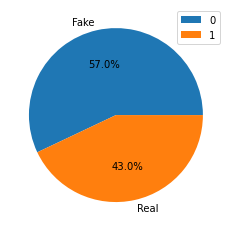

In [33]:
vc = eda_df['target'].value_counts()     
print(vc)
labels = ['Fake', 'Real']
plt.pie(vc,autopct='%1.1f%%',labels=labels)
plt.legend(vc.index, loc='best')
plt.show()

# **Hyperparameters and Tuning**
We need to define hyperparameters such as the batch size and learnign rate. This is done at the start of the code rather than later for readability.

Here is a list of what they do:
1. BATCH_SIZE : Defines how many items are used each training step
2. LEARNING_RATE : Defines the learning rate aka how much the models weights are updated each training step
3. EPOCHS : For how long the model will train for
4. VAL_SPLIT = This indicates how much data we use for training and validation. If it is set to 0.05, 95% of the dataset from train.csv will be used for training and the other 5% will be used to meassure the accuracy. 


EPOCHS and Learning rate were tuned after testing to improve the data.

In [8]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 100 #
VAL_SPLIT = 0.05

# **Initialize a list of stop words**
Stop words are words that do not add meaning to a sentence and are often removed prior to training. 

In [9]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jeffwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **The encoder/decoder function**
The encoder function splits the string into all of its words and looks up the index of each one. This way we get a list of integers that can be pased through the embedding layer of the model

In [10]:
vocabulary = []

def encode(str):
    return [vocabulary.index(word) for word in str.split(' ') if word not in stop_words]


def decode(seq):
    return "".join([vocabulary[index] for index in seq])

In [11]:
class dataset(Dataset):
    def __init__(self, split='train'):
        self.split = split
        
        if split == 'train':
            self.dataset = pd.read_csv('train.csv')
            '''self.dataset = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')'''
            self.dataset = self.dataset.iloc[:round(len(self.dataset) * (1 - VAL_SPLIT))]
            
            self.clean()
            
            self.X = self.dataset['text']
            self.Y = self.dataset['target']
        elif split == 'val':
            self.dataset = pd.read_csv('train.csv')
            '''self.dataset = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')'''
            self.dataset = self.dataset.iloc[round(len(self.dataset) * (1 - VAL_SPLIT)):]
            
            self.clean()
            
            self.X = self.dataset['text']
            self.Y = self.dataset['target']
        else:
            self.dataset = pd.read_csv('test.csv')
            '''self.dataset = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')'''
            self.clean()
            
            self.X = self.dataset['text']
    
    def add_vocab(self):
        for str in self.dataset['text']:
            for item in str.split(' '):
                if item not in vocabulary and item not in stop_words:
                    vocabulary.append(item)
            
    def clean(self):
        self.dataset['text'] = self.dataset['text'].str.lower()
        self.dataset['text'] = self.dataset['text'].str.replace('@\w+', '', regex=True) # remove usernames
        self.dataset['text'] = self.dataset['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
        
        self.add_vocab()
        
        self.dataset['text'] = self.dataset['text'].apply(encode)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.split == 'train' or self.split == 'val':
            return torch.tensor(self.X.iloc[idx], dtype=torch.long), torch.tensor(self.Y.iloc[idx], dtype=torch.long)
        else:
            return torch.tensor(self.X.iloc[idx], dtype=torch.long), torch.tensor(self.dataset['id'].iloc[idx], dtype=torch.int)

def collate_fn(batch):
    x, y = zip(*batch)
    return pad_sequence(x, batch_first=True, padding_value=0), torch.tensor(y)


In [18]:
eda_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
vc = self.train_df['target'].value_counts()     
            print(vc)
            labels = ['Fake', 'Real']
            plt.pie(vc,autopct='%1.1f%%',labels=labels)
            plt.legend(vc.index, loc='best')
            plt.show()

# **Creating the Model**
Our model consists of one [Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) and four [Fully connected layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). As the embedding layer expands the dimensions of our input, we use torch.mean to reduce its dimension.


## Model Architecture

The structure of the training network is based on PyTorch's training materials for text classification.

The model includes the following components:

- Input layer
- Vectorization layer: This layer is designed to standardize, tokenize, and vectorize the data. The vectorization process can be achieved with TorchText utilities.
- Hidden layers of the network, which include an embedding layer, pooling layer, and dense layer.
- The loss function used is CrossEntropyLoss.
- Optimization is performed using the Adam optimizer.
- Accuracy is used as the metric for evaluation.
- Training is stopped early if the validation accuracy doesn't increase for 3 consecutive epochs.
- Two versions of the model, one using integer vectorization and the other using binary vectorization, are tested. The hyperparameters are adjusted through multiple iterations to prevent overfitting and underfitting while maintaining acceptable accuracy.

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embedding = nn.Embedding(len(vocabulary), 256) # vocab size x embedding dimension
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.mean(x, dim=1) 
        x = self.fc4(x)
        
        return x
        

# **Training the model**
First of all we start off by creating two instances of the Dataset class, one for training, one for validation, one for testing. Then we create a DataLoader for each of them.

A new instance of our model, our optimizer and a CrossEntropyLoss function.

We define a function to calculate the accuracy by counting the total amount of correct predictions of a batch. 

We define a function to evaluate the models' performance on the validation dataset using the previously defined function.

Then for each epoch we loop through the batches and calculate the loss between the target batch and the networks predictions. Then we adjust the networks' weights and biases using backpropagation. The models' accuracy on the validation dataset is assesed after each epoch.


In [13]:
train_dataset = dataset(split='train')
trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_dataset = dataset(split='val')
valDataLoader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_dataset = dataset(split='test')
testDataLoader = DataLoader(test_dataset, batch_size=1, shuffle=False)

net = Classifier()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

def calculate_accuracy(predictions, targets):
    predicted_labels = torch.argmax(predictions, dim=1)
    correct_predictions = (predicted_labels == targets).sum().item()
    total_predictions = targets.size(0)
    accuracy = correct_predictions / total_predictions
    return accuracy

def evaluate():
    accuracies = []
    for idx, batch in enumerate(valDataLoader):
        x, y = batch
        
        with torch.no_grad():
            accuracies.append(calculate_accuracy(net.forward(x), y))
        
    print(f'Validation accuracy {np.average(accuracies)}')
    
for epoch in range(EPOCHS):
    progress_bar = tqdm(trainDataLoader)
    
    accuracies = []
    losses = []
    
    for index, (x, y) in enumerate(progress_bar):        
        optimizer.zero_grad()
        
        output = net.forward(x)
        
        loss = criterion(output, y)
        
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        accuracies.append(calculate_accuracy(output, y))
        
        progress_bar.set_description(f'Epoch [{epoch+1}/{EPOCHS}]')
        progress_bar.set_postfix(loss=np.average(losses), acc=np.average(accuracies))
        
    evaluate()

Epoch [1/100]: 100%|███| 113/113 [00:02<00:00, 38.65it/s, acc=0.574, loss=0.681]


Validation accuracy 0.453978825136612


Epoch [2/100]: 100%|███| 113/113 [00:02<00:00, 40.65it/s, acc=0.576, loss=0.677]


Validation accuracy 0.4542349726775956


Epoch [3/100]: 100%|███| 113/113 [00:02<00:00, 38.81it/s, acc=0.576, loss=0.676]


Validation accuracy 0.45436304644808745


Epoch [4/100]: 100%|███| 113/113 [00:02<00:00, 38.89it/s, acc=0.576, loss=0.674]


Validation accuracy 0.45385075136612024


Epoch [5/100]: 100%|███| 113/113 [00:02<00:00, 37.86it/s, acc=0.576, loss=0.674]


Validation accuracy 0.45137465846994534


Epoch [6/100]: 100%|███| 113/113 [00:02<00:00, 40.24it/s, acc=0.576, loss=0.673]


Validation accuracy 0.4568391393442623


Epoch [7/100]: 100%|███| 113/113 [00:02<00:00, 40.17it/s, acc=0.573, loss=0.672]


Validation accuracy 0.4516308060109289


Epoch [8/100]: 100%|███| 113/113 [00:02<00:00, 40.48it/s, acc=0.577, loss=0.671]


Validation accuracy 0.453978825136612


Epoch [9/100]: 100%|███| 113/113 [00:02<00:00, 39.69it/s, acc=0.573, loss=0.671]


Validation accuracy 0.45969945355191255


Epoch [10/100]: 100%|██| 113/113 [00:02<00:00, 39.84it/s, acc=0.575, loss=0.671]


Validation accuracy 0.4692196038251366


Epoch [11/100]: 100%|███| 113/113 [00:02<00:00, 40.16it/s, acc=0.577, loss=0.67]


Validation accuracy 0.46153517759562845


Epoch [12/100]: 100%|███| 113/113 [00:02<00:00, 41.34it/s, acc=0.579, loss=0.67]


Validation accuracy 0.47583674863387976


Epoch [13/100]: 100%|███| 113/113 [00:02<00:00, 42.84it/s, acc=0.576, loss=0.67]


Validation accuracy 0.46426741803278687


Epoch [14/100]: 100%|██| 113/113 [00:02<00:00, 42.41it/s, acc=0.575, loss=0.669]


Validation accuracy 0.47011612021857924


Epoch [15/100]: 100%|███| 113/113 [00:02<00:00, 43.18it/s, acc=0.575, loss=0.67]


Validation accuracy 0.47195184426229514


Epoch [16/100]: 100%|███| 113/113 [00:02<00:00, 42.77it/s, acc=0.573, loss=0.67]


Validation accuracy 0.4776724726775956


Epoch [17/100]: 100%|██| 113/113 [00:02<00:00, 43.66it/s, acc=0.577, loss=0.668]


Validation accuracy 0.47062841530054644


Epoch [18/100]: 100%|██| 113/113 [00:02<00:00, 42.64it/s, acc=0.574, loss=0.668]


Validation accuracy 0.4807889344262295


Epoch [19/100]: 100%|██| 113/113 [00:02<00:00, 43.86it/s, acc=0.578, loss=0.668]


Validation accuracy 0.48574112021857924


Epoch [20/100]: 100%|██| 113/113 [00:02<00:00, 41.79it/s, acc=0.582, loss=0.667]


Validation accuracy 0.4944501366120219


Epoch [21/100]: 100%|██| 113/113 [00:02<00:00, 38.81it/s, acc=0.576, loss=0.668]


Validation accuracy 0.4879610655737705


Epoch [22/100]: 100%|██| 113/113 [00:02<00:00, 40.34it/s, acc=0.581, loss=0.666]


Validation accuracy 0.5016222677595629


Epoch [23/100]: 100%|██| 113/113 [00:02<00:00, 40.79it/s, acc=0.578, loss=0.667]


Validation accuracy 0.4828808060109289


Epoch [24/100]: 100%|██| 113/113 [00:02<00:00, 42.42it/s, acc=0.581, loss=0.666]


Validation accuracy 0.5011099726775956


Epoch [25/100]: 100%|██| 113/113 [00:02<00:00, 39.94it/s, acc=0.578, loss=0.666]


Validation accuracy 0.4718237704918033


Epoch [26/100]: 100%|██| 113/113 [00:02<00:00, 40.96it/s, acc=0.582, loss=0.666]


Validation accuracy 0.48770491803278687


Epoch [27/100]: 100%|██| 113/113 [00:02<00:00, 39.24it/s, acc=0.583, loss=0.665]


Validation accuracy 0.4983777322404372


Epoch [28/100]: 100%|██| 113/113 [00:02<00:00, 41.42it/s, acc=0.584, loss=0.664]


Validation accuracy 0.5046106557377049


Epoch [29/100]: 100%|██| 113/113 [00:02<00:00, 38.81it/s, acc=0.589, loss=0.663]


Validation accuracy 0.48757684426229514


Epoch [30/100]: 100%|██| 113/113 [00:03<00:00, 37.59it/s, acc=0.585, loss=0.664]


Validation accuracy 0.4905652322404372


Epoch [31/100]: 100%|██| 113/113 [00:02<00:00, 38.48it/s, acc=0.585, loss=0.664]


Validation accuracy 0.49146174863387976


Epoch [32/100]: 100%|██| 113/113 [00:02<00:00, 38.84it/s, acc=0.586, loss=0.663]


Validation accuracy 0.514771174863388


Epoch [33/100]: 100%|██| 113/113 [00:02<00:00, 39.12it/s, acc=0.588, loss=0.662]


Validation accuracy 0.5037141393442622


Epoch [34/100]: 100%|███| 113/113 [00:02<00:00, 39.05it/s, acc=0.591, loss=0.66]


Validation accuracy 0.5040983606557378


Epoch [35/100]: 100%|██| 113/113 [00:02<00:00, 39.15it/s, acc=0.592, loss=0.661]


Validation accuracy 0.5060621584699453


Epoch [36/100]: 100%|██| 113/113 [00:02<00:00, 38.63it/s, acc=0.587, loss=0.661]


Validation accuracy 0.5126793032786886


Epoch [37/100]: 100%|███| 113/113 [00:02<00:00, 40.17it/s, acc=0.598, loss=0.66]


Validation accuracy 0.49876195355191255


Epoch [38/100]: 100%|██| 113/113 [00:02<00:00, 39.29it/s, acc=0.597, loss=0.657]


Validation accuracy 0.5009818989071039


Epoch [39/100]: 100%|██| 113/113 [00:02<00:00, 38.25it/s, acc=0.598, loss=0.658]


Validation accuracy 0.5061902322404371


Epoch [40/100]: 100%|██| 113/113 [00:02<00:00, 40.43it/s, acc=0.602, loss=0.656]


Validation accuracy 0.5091786202185792


Epoch [41/100]: 100%|██| 113/113 [00:02<00:00, 40.68it/s, acc=0.601, loss=0.655]


Validation accuracy 0.509306693989071


Epoch [42/100]: 100%|██| 113/113 [00:02<00:00, 38.87it/s, acc=0.606, loss=0.654]


Validation accuracy 0.508666325136612


Epoch [43/100]: 100%|██| 113/113 [00:02<00:00, 40.08it/s, acc=0.607, loss=0.654]


Validation accuracy 0.514130806010929


Epoch [44/100]: 100%|███| 113/113 [00:02<00:00, 40.62it/s, acc=0.618, loss=0.65]


Validation accuracy 0.537568306010929


Epoch [45/100]: 100%|███| 113/113 [00:02<00:00, 39.08it/s, acc=0.616, loss=0.65]


Validation accuracy 0.5271516393442622


Epoch [46/100]: 100%|██| 113/113 [00:02<00:00, 39.02it/s, acc=0.619, loss=0.647]


Validation accuracy 0.5223275273224044


Epoch [47/100]: 100%|██| 113/113 [00:02<00:00, 42.37it/s, acc=0.627, loss=0.644]


Validation accuracy 0.5302681010928961


Epoch [48/100]: 100%|██| 113/113 [00:02<00:00, 40.21it/s, acc=0.629, loss=0.644]


Validation accuracy 0.5367571721311476


Epoch [49/100]: 100%|██| 113/113 [00:02<00:00, 40.50it/s, acc=0.638, loss=0.639]


Validation accuracy 0.5740266393442622


Epoch [50/100]: 100%|██| 113/113 [00:02<00:00, 41.44it/s, acc=0.641, loss=0.636]


Validation accuracy 0.5770150273224044


Epoch [51/100]: 100%|██| 113/113 [00:02<00:00, 39.40it/s, acc=0.649, loss=0.633]


Validation accuracy 0.5667264344262295


Epoch [52/100]: 100%|██| 113/113 [00:02<00:00, 39.06it/s, acc=0.656, loss=0.628]


Validation accuracy 0.554474043715847


Epoch [53/100]: 100%|███| 113/113 [00:02<00:00, 41.30it/s, acc=0.66, loss=0.624]


Validation accuracy 0.5957564890710382


Epoch [54/100]: 100%|██| 113/113 [00:02<00:00, 39.72it/s, acc=0.674, loss=0.617]


Validation accuracy 0.6197062841530054


Epoch [55/100]: 100%|██| 113/113 [00:02<00:00, 41.26it/s, acc=0.678, loss=0.609]


Validation accuracy 0.6737534153005464


Epoch [56/100]: 100%|██| 113/113 [00:02<00:00, 41.70it/s, acc=0.688, loss=0.606]


Validation accuracy 0.680114412568306


Epoch [57/100]: 100%|██| 113/113 [00:02<00:00, 40.37it/s, acc=0.698, loss=0.596]


Validation accuracy 0.7010758196721311


Epoch [58/100]: 100%|██| 113/113 [00:02<00:00, 40.06it/s, acc=0.705, loss=0.588]


Validation accuracy 0.6460040983606558


Epoch [59/100]: 100%|██| 113/113 [00:02<00:00, 40.84it/s, acc=0.713, loss=0.581]


Validation accuracy 0.6745218579234972


Epoch [60/100]: 100%|██| 113/113 [00:02<00:00, 40.39it/s, acc=0.722, loss=0.571]


Validation accuracy 0.7137124316939891


Epoch [61/100]: 100%|███| 113/113 [00:02<00:00, 41.16it/s, acc=0.73, loss=0.561]


Validation accuracy 0.7202015027322405


Epoch [62/100]: 100%|██| 113/113 [00:02<00:00, 41.98it/s, acc=0.738, loss=0.551]


Validation accuracy 0.7139685792349727


Epoch [63/100]: 100%|██| 113/113 [00:02<00:00, 41.32it/s, acc=0.742, loss=0.541]


Validation accuracy 0.7324538934426229


Epoch [64/100]: 100%|███| 113/113 [00:02<00:00, 40.10it/s, acc=0.75, loss=0.533]


Validation accuracy 0.7190488387978142


Epoch [65/100]: 100%|██| 113/113 [00:02<00:00, 43.06it/s, acc=0.755, loss=0.525]


Validation accuracy 0.7375341530054644


Epoch [66/100]: 100%|██| 113/113 [00:02<00:00, 41.58it/s, acc=0.757, loss=0.517]


Validation accuracy 0.7320696721311476


Epoch [67/100]: 100%|███| 113/113 [00:02<00:00, 41.30it/s, acc=0.764, loss=0.51]


Validation accuracy 0.7617400956284154


Epoch [68/100]: 100%|██| 113/113 [00:02<00:00, 39.98it/s, acc=0.766, loss=0.502]


Validation accuracy 0.7429986338797815


Epoch [69/100]: 100%|██| 113/113 [00:02<00:00, 39.71it/s, acc=0.778, loss=0.493]


Validation accuracy 0.7480788934426229


Epoch [70/100]: 100%|██| 113/113 [00:02<00:00, 42.28it/s, acc=0.775, loss=0.488]


Validation accuracy 0.7459870218579235


Epoch [71/100]: 100%|██| 113/113 [00:02<00:00, 42.46it/s, acc=0.784, loss=0.479]


Validation accuracy 0.7398821721311476


Epoch [72/100]: 100%|██| 113/113 [00:02<00:00, 41.98it/s, acc=0.784, loss=0.475]


Validation accuracy 0.7532872267759562


Epoch [73/100]: 100%|███| 113/113 [00:02<00:00, 41.39it/s, acc=0.79, loss=0.469]


Validation accuracy 0.7686560792349727


Epoch [74/100]: 100%|██| 113/113 [00:02<00:00, 41.09it/s, acc=0.788, loss=0.465]


Validation accuracy 0.7458589480874317


Epoch [75/100]: 100%|██| 113/113 [00:02<00:00, 39.18it/s, acc=0.794, loss=0.457]


Validation accuracy 0.7640881147540983


Epoch [76/100]: 100%|██| 113/113 [00:02<00:00, 39.05it/s, acc=0.802, loss=0.447]


Validation accuracy 0.7764685792349727


Epoch [77/100]: 100%|██| 113/113 [00:02<00:00, 39.37it/s, acc=0.804, loss=0.443]


Validation accuracy 0.7774931693989071


Epoch [78/100]: 100%|██| 113/113 [00:02<00:00, 40.58it/s, acc=0.809, loss=0.437]


Validation accuracy 0.7349299863387978


Epoch [79/100]: 100%|███| 113/113 [00:02<00:00, 41.88it/s, acc=0.812, loss=0.43]


Validation accuracy 0.7717725409836066


Epoch [80/100]: 100%|██| 113/113 [00:02<00:00, 41.17it/s, acc=0.816, loss=0.424]


Validation accuracy 0.7851775956284154


Epoch [81/100]: 100%|██| 113/113 [00:02<00:00, 41.62it/s, acc=0.822, loss=0.416]


Validation accuracy 0.8009306693989071


Epoch [82/100]: 100%|██| 113/113 [00:02<00:00, 42.08it/s, acc=0.824, loss=0.408]


Validation accuracy 0.7929900956284154


Epoch [83/100]: 100%|██| 113/113 [00:02<00:00, 41.17it/s, acc=0.824, loss=0.406]


Validation accuracy 0.7742486338797815


Epoch [84/100]: 100%|██| 113/113 [00:02<00:00, 41.03it/s, acc=0.829, loss=0.397]


Validation accuracy 0.743254781420765


Epoch [85/100]: 100%|██| 113/113 [00:02<00:00, 41.35it/s, acc=0.828, loss=0.394]


Validation accuracy 0.7739924863387978


Epoch [86/100]: 100%|██| 113/113 [00:03<00:00, 36.85it/s, acc=0.834, loss=0.385]


Validation accuracy 0.789489412568306


Epoch [87/100]: 100%|██| 113/113 [00:02<00:00, 38.59it/s, acc=0.844, loss=0.374]


Validation accuracy 0.7900017076502732


Epoch [88/100]: 100%|██| 113/113 [00:02<00:00, 37.91it/s, acc=0.848, loss=0.365]


Validation accuracy 0.7873975409836066


Epoch [89/100]: 100%|██| 113/113 [00:02<00:00, 40.06it/s, acc=0.852, loss=0.359]


Validation accuracy 0.8008025956284154


Epoch [90/100]: 100%|██| 113/113 [00:02<00:00, 38.00it/s, acc=0.853, loss=0.351]


Validation accuracy 0.7976861338797815


Epoch [91/100]: 100%|██| 113/113 [00:02<00:00, 40.12it/s, acc=0.856, loss=0.348]


Validation accuracy 0.7949538934426229


Epoch [92/100]: 100%|██| 113/113 [00:02<00:00, 39.59it/s, acc=0.858, loss=0.341]


Validation accuracy 0.7974299863387978


Epoch [93/100]: 100%|██| 113/113 [00:02<00:00, 39.53it/s, acc=0.862, loss=0.331]


Validation accuracy 0.7957223360655737


Epoch [94/100]: 100%|██| 113/113 [00:02<00:00, 37.71it/s, acc=0.866, loss=0.331]


Validation accuracy 0.7953381147540983


Epoch [95/100]: 100%|██| 113/113 [00:02<00:00, 39.44it/s, acc=0.875, loss=0.318]


Validation accuracy 0.8004183743169399


Epoch [96/100]: 100%|███| 113/113 [00:02<00:00, 39.01it/s, acc=0.876, loss=0.31]


Validation accuracy 0.790129781420765


Epoch [97/100]: 100%|██| 113/113 [00:02<00:00, 39.34it/s, acc=0.868, loss=0.314]


Validation accuracy 0.795594262295082


Epoch [98/100]: 100%|██| 113/113 [00:02<00:00, 38.17it/s, acc=0.882, loss=0.297]


Validation accuracy 0.7900017076502732


Epoch [99/100]: 100%|███| 113/113 [00:03<00:00, 36.71it/s, acc=0.884, loss=0.29]


Validation accuracy 0.7876536885245903


Epoch [100/100]: 100%|█| 113/113 [00:02<00:00, 37.74it/s, acc=0.889, loss=0.285]


Validation accuracy 0.797301912568306


# Results and plots

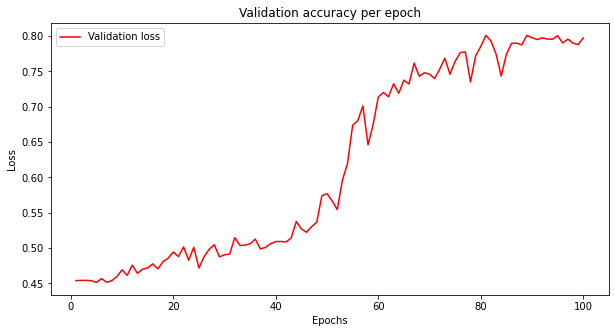

In [52]:
# Create a range of epochs. Length should match the length of your losses list.
epochs = range(1, len(validation_accuracies) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_accuracies, 'r', label='Validation Accuracy')
plt.title('Validation accuracy per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

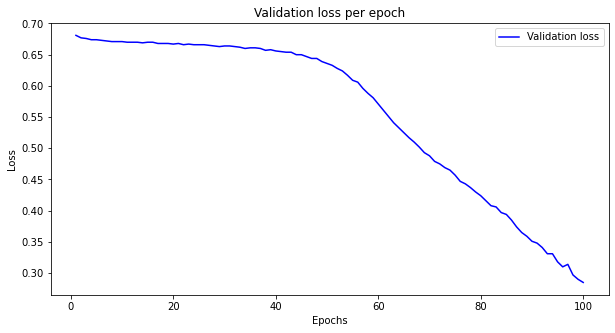

In [61]:
# Create a range of epochs. Length should match the length of your losses list.
epochs = range(1, len(val_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Validation loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Results

We see that validation loss decrease as epochs increase and validation accuracy increase, meaning our model is producing accurate predicitons on previously unseen data by the model. This also means there are no areas of overfitting. The final accuracy is .889, nearly 90% and with no signs of a plateau to show the model reaching its most optimum point. The final loss of .285 is a large improvement from the initial .681 loss of the first epoch. With our current model, we can automatically distinguish large portions of fake data. 

# Conclusion

Overall the model was a success in exercise. With a bit more epochs, time, and processing power, it is possible to get a higher accuracy, as shown by the lack of loss plateauing with the current model. However, although loss is still decreasing, we can see that accuracy is beginning to only get marginal improvements per epoch, meaning that there are diminishing returns for negligible improvements after the 100th epoch. 
Some other possible improvements could be:
- Test various word vector algorithms to optimize model performance.
- Experiment with a wide range of hyperparameters to enhance model convergence and performance.
- Upgrade or explore advanced network architectures to capture intricate patterns and boost overall performance.

# **Submission**

A new pandas DataFrame is created to hold the data. We then loop through the DataLoader and predict for each tweet. 

In [14]:
import pandas as pd

results = pd.DataFrame({'id': pd.Series(dtype=int), 'target': pd.Series()})

for batch in testDataLoader:
    text, id = batch
    output = net.forward(text)
    
    result_batch = pd.DataFrame({'id': [id.item()], 'target': [torch.argmax(output).item()]})
    results = pd.concat([results, result_batch])

results.to_csv('submission.csv', index=False)

/tmp/ipykernel_31538/3033033919.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results = pd.DataFrame({'id': pd.Series(dtype=int), 'target': pd.Series()})
